In [1]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np, matplotlib.colors as colors, os

In [18]:
# User input

# Locations of files and folders
in_folder = r'../datasets' # Master folder
out_folder = r'../tercile_plots' # Folder to save tercile plots to (only used if plot_terciles is set to True below)

site_folder = 'Sau_SP'  # Folder name for the site

# Variables from within the 'datasets' site folder that you want to extract forecasts for
# This is a dictionary, with key site_folder (set above), and returns a list of variables that must
# correspond to file names in 'datasets' folder
variable_list_dict = {'Vansjø_NO': ['tas','tp','Q','temp_0m','temp_15m'],
                      'MtBold_AUS': ['tas','tp','inflow_Q','surftemp','bottemp'],
                      'Sau_SP': ['tas','pr','Q','temp_surf','temp_bottom'],
                      'Wupper_GE': ['tas','tp','wupper_q','surftemp','bottemp']
                      }

# Set start and end years to include when calculating tercile boundaries.
# Date range 1994 to 2016 was used to calculate skill scores in re-forecasting
start_yr = 1994
end_yr = 2016

# Draw and save a tercile plot for the historic period?
plot_terciles = True

# Extract predictions for a single season and year? If so, which?
extract_predictions = True
season = 'winter' # choose from spring (march-may, summer (june-aug), autumn (sep-nov), winter (dec-feb)
year = 2010

Results for Sau_SP, winter, tas, 2010:
Modelled with ERA5: below
Season5 forecast probabilities:
s5 p(below)     0.20
s5 p(normal)    0.32
s5 p(above)     0.48
Name: 2010, dtype: float64

Results for Sau_SP, winter, pr, 2010:
Modelled with ERA5: above
Season5 forecast probabilities:
s5 p(below)     0.4
s5 p(normal)    0.2
s5 p(above)     0.4
Name: 2010, dtype: float64

Results for Sau_SP, winter, Q, 2010:
Observations: normal
Modelled with ERA5: normal
Season5 forecast probabilities:
s5 p(below)     0.52
s5 p(normal)    0.32
s5 p(above)     0.16
Name: 2010, dtype: float64

Results for Sau_SP, winter, temp_surf, 2010:
Modelled with ERA5: normal
Season5 forecast probabilities:
s5 p(below)     0.04
s5 p(normal)    0.20
s5 p(above)     0.76
Name: 2010, dtype: float64

Results for Sau_SP, winter, temp_bottom, 2010:
Modelled with ERA5: normal
Season5 forecast probabilities:
s5 p(below)     0.08
s5 p(normal)    0.92
s5 p(above)     0.00
Name: 2010, dtype: float64



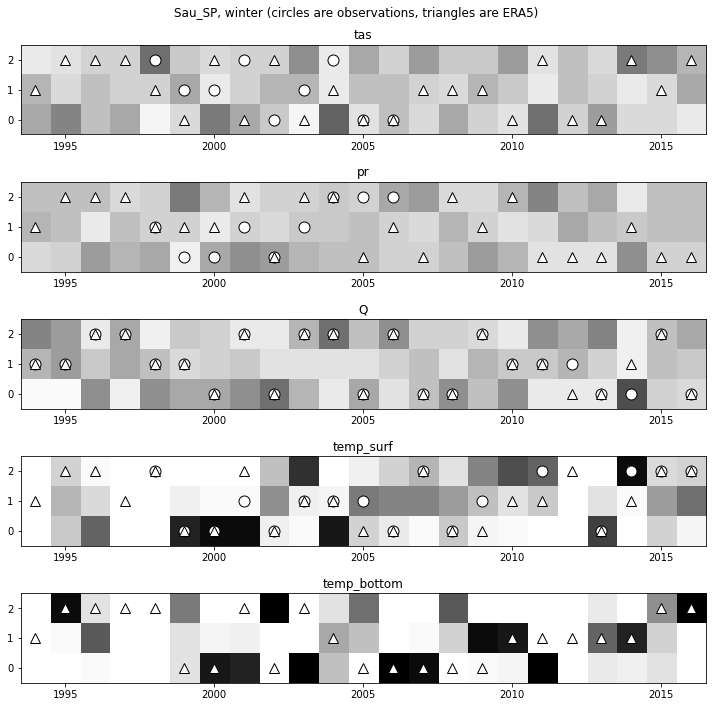

In [19]:
# Set up
if site_folder == 'Vansjø_NO':
    delimiter=';'
else:
    delimiter=','

variable_list = variable_list_dict[site_folder]

# Set the aggregation method for different variables
vars_to_sum = ['tp']#,'Q'] # Everything else is averaged (mean)   
    
# Define 4 seasons per year. Value is returned next to the last day of the season
def season_from_month(x):
    """Input month number,  return the season it corresponds to
    """
    if x in [12,1,2]:
        return 'winter'
    if x in [3,4,5]:
        return 'spring'
    if x in [6,7,8]:
        return 'summer'
    if x in [9,10,11]:
        return 'autumn'

integer_to_text_dict = {0:'below',1:'normal',2:'above', np.NaN:'No data'}

if plot_terciles == True:
    # Set up for plotting
    fig = plt.figure(figsize=(10,len(variable_list)*2))

# Read in data and process
for i, variable in enumerate(variable_list):
    infilepath = os.path.join(in_folder,site_folder, '%s.csv' %(variable))
    df = pd.read_csv(infilepath, index_col=0, parse_dates=True, dayfirst=True, delimiter=delimiter)
    
    # Rename column names so they are all uniform across sites and variables
    memberlist = [f'm_{i:02d}' for i in range(1, 26)]
    df.columns = ['obs','ERA5']+memberlist
    
    # Resample (enter 'Q' for quarterly, and '-month' for month to end in)
    # N.B. if the season split changes, need to change this too
    if variable in vars_to_sum:
        season_df = df.resample('Q-Feb').sum(min_count=80)
    else:
        season_df = df.resample('Q-Feb').mean()

    # Just select rows corresponding to the season of interest for each year
    target_season_df = season_df.loc[season_df.index.month.map(season_from_month)==season].copy()
    
    # Reindex with the year
    target_season_df['year'] = target_season_df.index.year
    target_season_df.set_index('year', inplace=True)
    
    # Truncate to desired start and end years
    target_season_df = target_season_df.loc[start_yr:end_yr,:]
    
    # Assign terciles for each series
    
    terc_df = pd.DataFrame() # Dataframe for obs and era5 terciles
    
    terc_df['ERA5'] = pd.qcut(target_season_df['ERA5'], 3, labels=False)     # ERA5
    
    # Only calculate terciles for the observations and plot them on tercile plot if have more than 9 years of data
    if target_season_df['obs'].notnull().sum()>=9:
        terc_df['obs'] = pd.qcut(target_season_df['obs'], 3, labels=False)     # Observations
        include_obs_output = True
    else:
        include_obs_output = False
    
    s5_terc_df = pd.DataFrame() # Separate dataframe for S5 terciles
    for idx, col in enumerate([f'm_{i:02d}' for i in range(1, 26)]):        # S5 ensemble memebers
        s5_terc_df[f'm_{idx+1:02d}'] = pd.qcut(target_season_df[col], 3, labels=False)
    
    # Create dataframe of S5 probs for each tercile
    s5_probs = pd.DataFrame({'s5 p(below)':(s5_terc_df == 0).sum(axis=1),
                            's5 p(normal)':(s5_terc_df == 1).sum(axis=1),
                            's5 p(above)':(s5_terc_df == 2).sum(axis=1),
                            }) / 25
    
    if plot_terciles == True:
        # Quick tercile plot
        ax = fig.add_subplot(len(variable_list),1,i+1)
        xlims = [s5_probs.index[0]-0.5,s5_probs.index[-1]+0.5]
        im = ax.imshow(s5_probs.T.values, cmap='Greys', origin='lower',
                  norm=colors.Normalize(vmin=0.0,vmax=1.0),
                      extent = [xlims[0], xlims[1],  -0.5, 2.5],
                      aspect='equal')
        if include_obs_output == True:
            plt.plot(terc_df.index, terc_df['obs'], marker='o', markersize=11,
                     lw=0, markerfacecolor='1', markeredgecolor='k')
        plt.plot(terc_df.index, terc_df['ERA5'], marker='^', markersize=10,
                lw=0, markerfacecolor='1', markeredgecolor='k')

        ax.set_title('%s' %variable);
    
    if extract_predictions == True:
        # Display output for a season of interest
        print('Results for %s, %s, %s, %s:' %(site_folder, season, variable, year))
        if include_obs_output == True and not np.isnan(terc_df.loc[year,'obs']):
            print('Observations: %s' %integer_to_text_dict[terc_df.loc[year,'obs']])
        print('Modelled with ERA5: %s' %integer_to_text_dict[terc_df.loc[year,'ERA5']])
        print('Season5 forecast probabilities:\n%s\n' %s5_probs.loc[year])

if plot_terciles == True:
    # Finalise figure, display and save
    fig.suptitle('%s, %s (circles are observations, triangles are ERA5)' %(site_folder, season))
    # cbar = fig.colorbar(im, ticks=[0, 0.5, 1])
    plt.tight_layout()
    plt.savefig(os.path.join(out_folder,'TercilePlot_%s_%s.png' %(site_folder,season)))
    plt.show()